In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from sklearn.metrics import davies_bouldin_score

In [2]:
import warnings
warnings.filterwarnings("ignore")

## import and merge two datasets

In [3]:
df=pd.read_csv('song_data.csv')
df.head()

,song_id,title,release,artist_name,year
0,SOQMMHC12AB0180CB8,Silent Night,Monster Ballads X-Mas,Faster Pussy cat,2003
1,SOVFVAK12A8C1350D9,Tanssi vaan,Karkuteillä,Karkkiautomaatti,1995
2,SOGTUKN12AB017F4F1,No One Could Ever,Butter,Hudson Mohawke,2006
3,SOBNYVR12A8C13558C,Si Vos Querés,De Culo,Yerba Brava,2003
4,SOHSBXH12A8C13B0DF,Tangle Of Aspens,Rene Ablaze Presents Winter Sessions,Der Mystic,0


In [4]:
df=df.drop_duplicates(['song_id'])

In [5]:
Num_Play = pd.read_csv('10000.txt', sep='\t', header=None, names=['user','song_id','play_count'])
Num_Play.head()

,user,song_id,play_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1


In [6]:
df_merge= pd.merge(Num_Play,df, how='left',on='song_id')
df_merge.head()

,user,song_id,play_count,title,release,artist_name,year
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson,0
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Stronger,Graduation,Kanye West,2007
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,Constellations,In Between Dreams,Jack Johnson,2005
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999


In [7]:
title =df_merge.groupby(['title'])['play_count'].count().sort_values(ascending=False)
title=title.to_frame().head(20)
title

,play_count
title,
Sehr kosmisch,8277
Undo,7032
Dog Days Are Over (Radio Edit),6949
You're The One,6729
Revelry,6145
Secrets,5841
Horn Concerto No. 4 in E flat K495: II. Romance (Andante cantabile),5385
Fireflies,4795
Hey_ Soul Sister,4758


Text(0, 0.5, 'Item count')

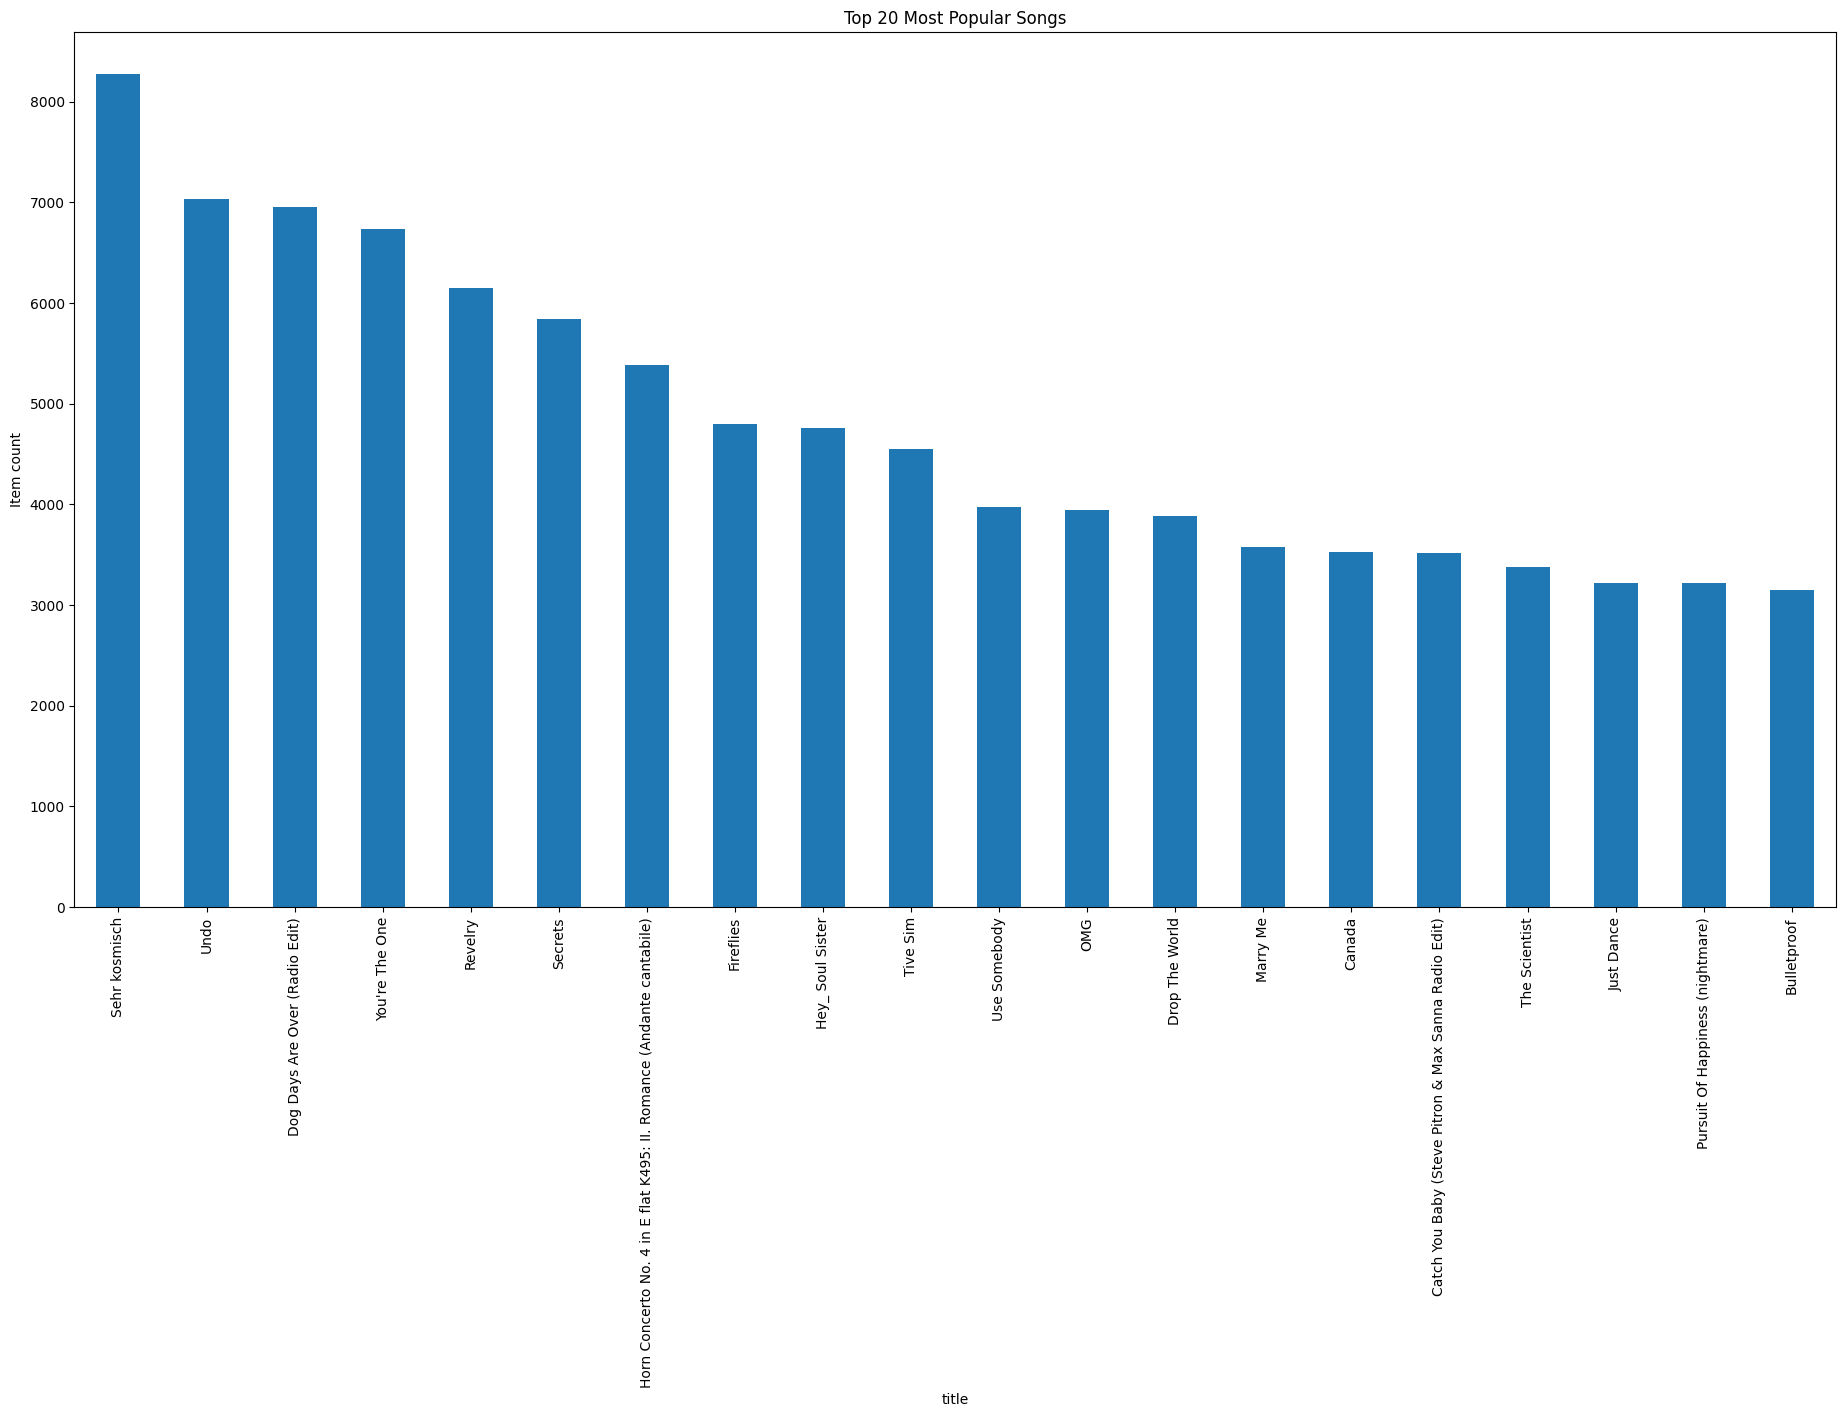

In [8]:
fig = plt.figure(figsize=(50, 25))
a1 = fig.add_subplot(221)
f1 = title.plot(kind='bar', title='Top 20 Most Popular Songs', legend=False, ax=a1)
plt.xticks(rotation='vertical')
plt.ylabel('Item count')

## Recommend system item_based collaborative

## 1.NearestNeighbors

In [8]:
min_ratings = 150

print("Number of songs which have more than {} listening: {}".format(min_ratings, len(df[df[('user', 'count')]>=min_ratings])))

Number of songs which have more than 150 listening: 3892


In [9]:
df_top_songs = df[df[('user', 'count')]>=min_ratings]

df_ratings_with_top_songs = df_merge[df_merge['song_id'].isin(list(df_top_songs.index))]

In [10]:
min_songs_rated = 150

df_users = df_ratings_with_top_songs[['song_id','user']].groupby(['user']).agg(['count']).sort_values(('song_id','count'),ascending=False)

df_top_rating_users = df_users[df_users[('song_id', 'count')]>=min_songs_rated]

top_rating_users = list(df_top_rating_users.index)

df_final=df_ratings_with_top_songs[df_ratings_with_top_songs['user'].isin(top_rating_users)]

In [17]:
df_user_item_matrix = df_final.pivot(index='song_id',columns='user',values='play_count').fillna(0)

In [19]:
user_item_matrix_sparse = csr_matrix(df_user_item_matrix.values)

In [20]:
from sklearn.neighbors import NearestNeighbors

In [21]:
model = NearestNeighbors(n_neighbors=30, metric='cosine', algorithm='brute', n_jobs=-1)

model.fit(user_item_matrix_sparse)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=30)

In [24]:
index_to_song = dict()

df_titles_song = df_merge.set_index('song_id').loc[df_user_item_matrix.index]

count = 0

for index, row in df_titles_song.iterrows():

    index_to_song[count]=row['title']

    count +=1


def recommender(model, user_item_matrix_sparse, df_merge, number_of_recommendations, song_index):

    main_title = index_to_song[song_index]

    dist, ind = model.kneighbors(user_item_matrix_sparse[song_index], n_neighbors=number_of_recommendations+1)

    dist = dist[0].tolist()

    ind = ind[0].tolist()

    titles = []

    for index in ind:

        titles.append(index_to_song[index])

    recommendations = list(zip(titles,dist))    

    # sort recommendations

    recommendations_sorted = sorted(recommendations, key = lambda x:x[1])

    # reverse recommendations, leaving out the first element 

    recommendations_sorted.reverse()

    recommendations_sorted = recommendations_sorted[:-1]

    print("10 Recommendations for song {}: ".format(main_title))

    count = 0

    for (title, distance) in recommendations_sorted:

        count += 1

        print('{}. {}, recommendation score = {}'.format(count, title, round(distance,3)))

recommender(model, user_item_matrix_sparse, df_merge, 10, 1)

10 Recommendations for song Rome Wasn't Built In A Day: 
1. STARSTRUKK [FEATURINGKATYPERRY] (Explicit Bonus Version), recommendation score = 0.461
2. 221, recommendation score = 0.461
3. Juke Box Hero (Remastered LP Version ), recommendation score = 0.446
4. Hallelujah (Album Version), recommendation score = 0.438
5. I Hate Everything About You, recommendation score = 0.413
6. STARSTRUKK [FEATURINGKATYPERRY] (Explicit Bonus Version), recommendation score = 0.401
7. Rome Wasn't Built In A Day, recommendation score = 0.384
8. Rome Wasn't Built In A Day, recommendation score = 0.378
9. Rome Wasn't Built In A Day, recommendation score = 0.375
10. STARSTRUKK [FEATURINGKATYPERRY] (Explicit Bonus Version), recommendation score = 0.357


# 2.Corrwith method

In [8]:
song_user = df_merge.groupby('user')['song_id'].count()

#Try to filter the user who listan more than 150
song_more20 = song_user[song_user >150].index.to_list()
df_song_id_more_ten = df_merge[df_merge['user'].isin(song_more20)].reset_index(drop=True)

In [71]:
matrix = df_song_id_more_ten.pivot_table(index=['user'], columns='title', values='play_count').fillna(0)
matrix

title,#!*@ You Tonight [Featuring R. Kelly] (Explicit Album Version),#40,& Down,' Cello Song,'97 Bonnie & Clyde,'Round Midnight,'Til We Die (Album Version),'Till I Collapse,('Til) I Kissed You,(Anaesthesia) Pulling Teath,...,sillyworld (Album Version),sleep_ eat food_ have visions,smile around the face,sun drums and soil,teachme (Album Version),the Love Song,you were there with me,¡Viva La Gloria! (Album Version),¿Lo Ves? [Piano Y Voz],Época
user,,,,,,,,,,,,,,,,,,,,,
00185e316f07f0f00c325ca034be59c15b362401,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
003d0f3aac94fd261bb74c0124a90750579972d4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00544d8bde0d7985e8d703c1eb676d41cad33c67,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
007a631c3627babb8fb84d654b2d651c6c471c64,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
009fab78deabfd28481ce0123f5a9894c094d971,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffc564b85d81f0ea427cee3eea2415cc2fc5c4be,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ffd458f903d49854685cf4540245c1d297e8bafa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ffdaab327f2fc6b9fa01a4e3e7f41fdd0e468046,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Test Item_based collborative

In [14]:
Undo_title=matrix['Undo']


In [73]:
Undo_music=pd.DataFrame(matrix.corrwith(Undo_title),columns=['correlations']).sort_values(by=['correlations'],ascending=False)

In [68]:
Undo_music.head(10)

,correlations
title,
Undo,1.000000
Horn Concerto No. 4 in E flat K495: II. Romance (Andante cantabile),0.552071
Catch You Baby (Steve Pitron & Max Sanna Radio Edit),0.510228
Drop The World,0.493327
Sehr kosmisch,0.492029
You're The One,0.491186
Secrets,0.486267
Hey_ Soul Sister,0.440228
Fireflies,0.434770


## User_based collaborative and make sparse matrix

In [23]:
user_song_list_listen = df_merge[['user','play_count']].groupby('user').sum().reset_index()
user_song_list_listen.rename(columns={'play_count':'total_play'},inplace=True)
merged = pd.merge(df_merge,user_song_list_listen).sort_values(by='play_count',ascending=False)
merged=merged[merged['play_count']>30]

merged

,user,song_id,play_count,title,release,artist_name,year,total_play
1228366,d13609d62db6df876d3cc388225478618bb7b912,SOFCGSE12AF72A674F,2213,Starshine,Gorillaz,Gorillaz,2000,2686
1048310,50996bbabb6f7857bf0c8019435b5246a0e45cfd,SOUAGPQ12A8AE47B3A,920,Crack Under Pressure,Stress related / Live and learn,Righteous Pigs,1998,988
1586780,5ea608df0357ec4fda191cb9316fe8e6e65e3777,SOKOSPK12A8C13C088,879,Call It Off (Album Version),The Con,Tegan And Sara,2007,2032
31179,bb85bb79612e5373ac714fcd4469cabeb5ed94e1,SOZQSVB12A8C13C271,796,Paradise & Dreams,Skydivin',Darren Styles,0,964
1875121,c012ec364329bb08cbe3e62fe76db31f8c5d8ec3,SOBONKR12A58A7A7E0,683,You're The One,If There Was A Way,Dwight Yoakam,1990,1712
...,...,...,...,...,...,...,...,...
901275,a31b11c667e351b4e15368538e6623be93d63676,SOQLVIT12A8C137EA2,31,Sleep Through The Static,Sleep Through The Static,Jack Johnson,2008,216
204929,a2f600b2831a6d6ac7110c22fc8773d96a95aebd,SONDKOF12A6D4F7D70,31,Recado Falado (Metrô Da Saudade),2 Em 1,Alceu Valença,0,136
1931775,7edc9d6c880eec6f25cfd6b888518d7b06fbec61,SOZBZSY12A6D4FA404,31,Boys Don't Cry,Starter For 10: Original Motion Picture Soundt...,The Cure,1979,325
932240,63f18e848b9adadb5db81392f206f46b47ea28f4,SOPQDHP12A8C1346E2,31,Hei okei mä meen,Karkuteillä,Karkkiautomaatti,1995,281


In [21]:
merged=merged.drop(['release','year'],axis=1)


In [22]:
# Calculate the score of music that each user how much listen to a music from total
merged['score'] =merged['play_count']/merged['total_play']
merged.sort_values(by='play_count',ascending=False)

,user,song_id,play_count,title,artist_name,total_play,score
1228366,d13609d62db6df876d3cc388225478618bb7b912,SOFCGSE12AF72A674F,2213,Starshine,Gorillaz,2686,0.823902
1048310,50996bbabb6f7857bf0c8019435b5246a0e45cfd,SOUAGPQ12A8AE47B3A,920,Crack Under Pressure,Righteous Pigs,988,0.931174
1586780,5ea608df0357ec4fda191cb9316fe8e6e65e3777,SOKOSPK12A8C13C088,879,Call It Off (Album Version),Tegan And Sara,2032,0.432579
31179,bb85bb79612e5373ac714fcd4469cabeb5ed94e1,SOZQSVB12A8C13C271,796,Paradise & Dreams,Darren Styles,964,0.825726
1875121,c012ec364329bb08cbe3e62fe76db31f8c5d8ec3,SOBONKR12A58A7A7E0,683,You're The One,Dwight Yoakam,1712,0.398949
...,...,...,...,...,...,...,...
1101189,947c44d62da1c4c633b44204d3a41bd17848e67e,SOZSWRJ12A6D4FC3AB,31,Heart Attack and Vine,Screamin' Jay Hawkins,143,0.216783
492468,b2bc8e23a46c5d8e0db0639e0a2a7f7fa0a79d5c,SOBONKR12A58A7A7E0,31,You're The One,Dwight Yoakam,512,0.060547
25158,b08c89c2ba53c413375602b3d4687d4f9b260593,SOYPWKK12A8C136494,31,Ready_ Steady_ Go (Album Version),Paul Oakenfold,215,0.144186
25154,b08c89c2ba53c413375602b3d4687d4f9b260593,SOOJWBH12A6D4F64E3,31,Mongoloid,Devo,215,0.144186


In [10]:
user_codes = merged.user.drop_duplicates().reset_index()
user_codes.rename(columns={'index':'user_index'}, inplace=True)
user_codes['user_idx'] = list(user_codes.index)

In [11]:
song_codes =merged.song_id.drop_duplicates().reset_index()
song_codes.rename(columns={'index':'song_idx'}, inplace=True)
song_codes['song_idx'] = list(song_codes.index)

In [12]:
new_set = pd.merge(merged,song_codes,how='left')
new_set = pd.merge(new_set,user_codes,how='left')
final = new_set[['user_idx','song_idx','score']]


## Recommended engine with SVD matrix

In [33]:
data_array = final.score.values
row_array = final.user_idx.values
col_array =final.song_idx.values
data_sparse = coo_matrix((data_array, (row_array, col_array)),dtype=float)

In [1]:
from scipy.sparse.linalg import svds
import math as mt
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import *
from scipy.sparse import coo_matrix

In [35]:
def compute_svd(urm, K):
    U, s, Vt = svds(urm, K)

    dim = (len(s), len(s))
    S = np.zeros(dim, dtype=np.float32)
    for i in range(0, len(s)):
        S[i,i] = mt.sqrt(s[i])

    U = csc_matrix(U, dtype=np.float32)
    S = csc_matrix(S, dtype=np.float32)
    Vt = csc_matrix(Vt, dtype=np.float32)
    
    return U, S, Vt

In [93]:
def compute_estimated_matrix(urm, U, S, Vt, uTest, K, test):
    rightTerm = S*Vt 
    estimatedRatings = np.zeros(shape=(MAX_UID, MAX_PID), dtype=np.float16)
    for userTest in uTest:
        prod = U[userTest, :]*rightTerm
        estimatedRatings[userTest, :] = prod.todense()
        recomendRatings = (-estimatedRatings[userTest, :]).argsort()[:250]
    return recomendRatings[1:]

In [176]:
K=50
urm = data_sparse
MAX_PID = urm.shape[1]
MAX_UID = urm.shape[0]

U, S, Vt = compute_svd(urm, K)
uTest = [8]

recommended_song = compute_estimated_matrix(urm, U, S, Vt, uTest, K, True)


In [175]:
print(f"The top five recommended song for user {new_set['user'][uTest]} is:")
for idx in recommended_song[:6]:
    for i,j in enumerate(new_set['song_idx']):
        # print(j)
        if idx==j:
            print( new_set['title'][idx])
            break
            

The top five recommended song for user 8    f5363481018dc87e8b06f9451e99804610a594fa
Name: user, dtype: object is:
Casting A Spell (Remixed) (1998 Digital Remaster)
Funkytown
Breakfast At Tiffany's
Alma De Diamante
Mala Vida
You're The One
